# SA from Louvain

## Import Necessary Modules

In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
import matplotlib.colors as mcolors

## Functions

`plot_com(G, com)` - plots the network where colours indicate different communities.\
`generate_com_from_df(df)` - transforms dataframe information with row corresponding to protein, community number to a dictionary with key being community number and value a list of protiens.\
`local_move(node, coms)` - take a random node and accepts nodes via the Metropolis-Hasting condition. This is only implemented after certain temperature is met.\
`global_split(coms)` - takes a random community and performs a split if the Metropolis-Hasting condition is satisfied.\
`global_merge(coms)` - takes two random communities and performs a merge if the Metropolis-Hasting condition is satisfied.\
`brute_move(node, coms)` - takes a node and moves it to the community that optimizes modularity the most. This is the final call that will take missed nodes of degree 0 and place them appropriately.


In [2]:
global G #unchanged
global T #temperature scheme

def plot_coms(G, coms):
    colour_map = []

    colour_dict = {}
    for com in coms:
        colour_dict[com] = random_color_generator()

    for node in G:
        for com in coms:
            if node in coms[com]:
                colour_map.append(colour_dict[com])
    nx.draw(G, node_color=colour_map)


def generate_com_from_df(df):
    coms = {}
    for row, node in df.iterrows():
        if node[1] not in coms:
            coms[node[1]] = []
        coms[node[1]].append(node[0])
    return coms

def generate_com_from_dict(dict):
    coms = {}
    for node, com in dict.items():
        if com not in coms:
            coms[com] =[]
        coms[com].append(node)
    return coms

def generate_node_dict(coms=dict):
    node_dict = {}
    for key, value in coms.items():
        for node in value:
            node_dict[node] = key

    return node_dict


def random_color_generator():
    color = random.choice(list(mcolors.CSS4_COLORS.keys()))
    return color

def find_com(node, coms):
    for com in coms:
            #find which community the node is in
            if node in coms[com]:
                 return com
        
def create_partition(coms):
    return list(coms.values())
    

def accept_score(new, old):
    if new >= old: 
        return 1
    # else:
    #     p = np.exp((new-old)/T)
    #     if np.random.uniform(0, 1) < p:
    #         return 1


def T_scheme():
    return 0.98*T

def local_moves(node, coms):
    #find initial partition
    partition = create_partition(coms)
    #calculate initial modularity 
    mod_score = nx.community.modularity(G, partition)
    # print(mod_score)
    #find community of node
    pos_com = find_com(node, coms)
    #remove node so we can place in other partition
    coms[pos_com].remove(node)

    #find random community
    com = random.randint(0, len(coms)-1)
    while com == pos_com:
        com = random.randint(0, len(coms)-1)
    #place node in new partition
    coms[com].append(node)

    partition = create_partition(coms)
    
    new_mod_score = nx.community.modularity(G, partition)
    if accept_score(new_mod_score, mod_score):
        pos_com = com
        mod_score = new_mod_score
        return coms

    #place back in original community
    coms[com].remove(node)
    coms[pos_com].append(node)
    return coms

def global_split(coms):
    partition = create_partition(coms)
    old = nx.community.modularity(G, partition)

    r1 = random.randint(0, len(coms)-1)
    part = coms[r1]
    
    while len(part) <= 1:
        r1 = random.randint(0, len(coms)-1)
        part = coms[r1]

    H = G.subgraph(part)
    part2 = nx.community.kernighan_lin_bisection(H)
    coms[r1] = list(part2[0])
    coms[len(coms)] = list(part2[1])

    partition = create_partition(coms)
    new = nx.community.modularity(G, partition)
    if accept_score(new, old):
        return coms
    coms[r1] = part
    del coms[len(coms)-1]
    return coms

def global_merge(coms):
    partition = create_partition(coms)
    old = nx.community.modularity(G, partition)
    r1 = random.randint(0, len(coms)-1)
    r2 = random.randint(0, len(coms)-1)
    while r2 == r1:
        r2 = random.randint(0, len(coms)-1)
    com1 = coms[r1]
    com2 = coms[r2]
    coms[min(r1, r2)] = coms[r1] + coms[r2]

    del coms[max(r1, r2)]
    partition = create_partition(coms)
    new = nx.community.modularity(G, partition)
    #change the label suffle after the deletion.
    if accept_score(new, old):
        for num in range(max(r1, r2)+1, len(coms)+1):
            element = coms.pop(num)
            coms[num-1] = element
    else:    
        coms[r1] = com1
        coms[r2] = com2
    return coms

## Read Cleaned Network and Initial Partition

In [3]:
G0 = nx.read_edgelist('largestComponentData_without_weight.txt', nodetype=str, comments='#')

partition = pd.read_csv('partition_louvain.txt', delimiter=' ', names = [0, 1])
coms = generate_com_from_df(partition)
node_dict = generate_node_dict(coms)
target = ["YDL090C", 'YJR117W', 'YMR274C']
target_nums = []
for node in target:
    target_nums.append(node_dict[node])

#read community as graph
target_num = np.unique(target_nums)[0]
G = G0.subgraph(coms[target_num])

In [4]:
# STARTING PARAMETERS
T = 10**(-3)
num_coms =20
num_global_moves = len(G)
#global moves are creating a bipartition (we use KL) and then merging with other communities

## Global Moves

T=9.4069937617359e-05 score:0.6977

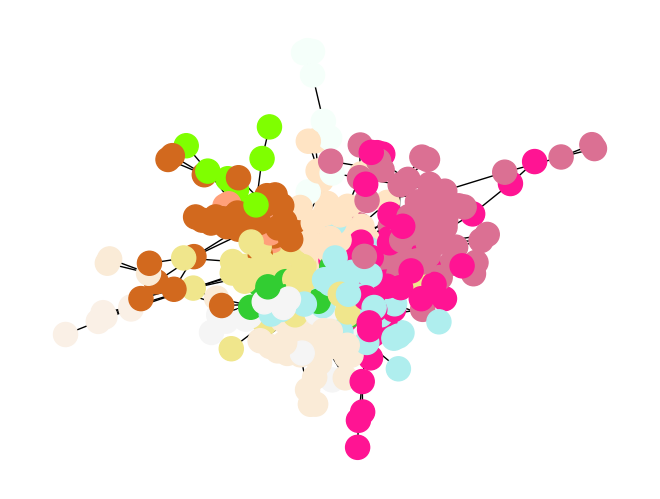

In [7]:
nodes = list(G.nodes())
partition = pd.read_csv('inner_louvain_partition.csv', names = [0, 1])
coms = generate_com_from_df(partition)

while T > 9e-5:
    # for node in G.nodes():
    for gmove in range(num_global_moves):
        if gmove%2 == 0:
            coms = global_merge(coms)
        else:
            coms = global_split(coms)

        partition = create_partition(coms)
        print(f'\rT={T} score:{nx.community.modularity(G, partition):.4f}', end='', flush=True)
    T = T_scheme() 
plot_coms(G, coms)

## Local Moves

In [11]:
while T > 8.8e-5:
    for gmove in range(num_global_moves):
        if gmove%2 == 0:
            coms = global_merge(coms)
        else:
            coms = global_split(coms)

        for lmove in range(num_global_moves):
            node = nodes[random.randint(0, len(G.nodes())-1)]
            coms = local_moves(node, coms) 
              
            partition = create_partition(coms)
            print(f'\rT={T} score:{nx.community.modularity(G, partition):.4f}', end='', flush=True)
    T = T_scheme() 

T=7.619664947006078e-05 score:0.6997

## Export Results

In [9]:
node_dict = generate_node_dict(coms)
target_nums = []
for node in target:
    target_nums.append(node_dict[node])
print(target_nums)
print(len(coms[target_nums[0]]))

[10, 10, 10]
33


In [10]:
node_df = pd.DataFrame.from_dict(node_dict, orient='index')
node_df.to_csv(f'LOUVAIN_SA_in_LOUVAIN_final.csv', header=False)